## Libraries imports

In [37]:
import pandas as pd
import numpy as np

import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error

## Data imports

In [2]:
data = pd.read_csv("data_02.csv")

C:\Users\julie\AppData\Local\Temp\ipykernel_19996\2542648378.py:1: DtypeWarning: Columns (6129) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("data_02.csv")


In [5]:
var_names = pd.read_csv("data_names_var_index.csv")

In [6]:
health_index = pd.read_csv("data_tSNE_GHI.csv")
health_index.head()

,HHIDPN,tSNE_GHI1,tSNE_GHI2,tSNE_GHI3,tSNE_GHI4,tSNE_GHI5,tSNE_GHI6,tSNE_GHI7,tSNE_GHI8,tSNE_GHI9,tSNE_GHI10,tSNE_GHI11,tSNE_GHI12,tSNE_GHI13,tSNE_GHI14
0,1010,46.338680,68.969490,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010,64.833760,-13.297101,27.734835,43.220688,44.066593,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3010,22.931510,-66.686300,-29.234972,13.921358,-91.249150,-44.982487,-73.210106,-93.987110,-26.113197,-49.452682,-13.593910,NaN,NaN,NaN
3,3020,87.220850,26.626232,-3.540929,-35.344840,5.839192,15.979321,87.244750,7.659104,7.514696,11.224237,6.606269,85.520730,NaN,NaN
4,10001010,16.348322,51.236960,-34.807380,16.018581,-20.836510,-49.169600,-41.571840,-27.421490,104.275900,-33.672630,-10.305906,-51.743675,-60.904327,NaN


In [7]:
var_names = var_names.drop(index=12).reset_index(drop=True) # We drop the variable RwSTATUS

RwAGEY_B = dict(zip(var_names.columns, ["cont"]+[f"R{wave}AGEY_B" for wave in range(1,15)]))
var_names = var_names.append(RwAGEY_B, ignore_index=True) # We add the age variable, as it is interesting

C:\Users\julie\AppData\Local\Temp\ipykernel_19996\375082379.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  var_names = var_names.append(RwAGEY_B, ignore_index=True) # We add the age variable, as it is interesting


In [8]:
in_waves = [f"INW{wave}" for wave in range(1, 15)]

In [9]:
health_variables = list(var_names.drop(columns="CAT_CONT").values.flatten())
health_data = data[["HHIDPN"] + in_waves + health_variables]

In [10]:
print(health_data.shape)
health_data.head()

(42233, 393)


,HHIDPN,INW1,INW2,INW3,INW4,INW5,INW6,INW7,INW8,INW9,...,R5AGEY_B,R6AGEY_B,R7AGEY_B,R8AGEY_B,R9AGEY_B,R10AGEY_B,R11AGEY_B,R12AGEY_B,R13AGEY_B,R14AGEY_B
0,1010,1,1,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010,1,1,1,1,1,0,0,0,0,...,65.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3010,1,1,1,1,1,1,1,1,1,...,64.0,66.0,68.0,70.0,72.0,74.0,76.0,NaN,NaN,NaN
3,3020,1,1,1,1,1,1,1,1,1,...,61.0,63.0,65.0,67.0,69.0,72.0,73.0,75.0,NaN,NaN
4,10001010,1,1,1,1,1,1,1,1,1,...,60.0,62.0,64.0,66.0,69.0,71.0,72.0,74.0,76.0,NaN


In [11]:
def get_wave(df, wave):
    assert wave > 0
    assert wave <= 14
    assert isinstance(wave, int)

    health_variables_for_this_wave = list(var_names[f"health_var_{wave}"].values)
  
    return df.loc[df[f"INW{wave}"] == 1, health_variables_for_this_wave + ["HHIDPN"]]

## Analysis of sensitivity

An analysis of sensitivity consists in testing the robustness of an index to changes in the data or in the assumptions made.
We will conduct different scenarios with different input data and compare the results.

First, we select a random sample of the data to create the index on this data only, and compare the results.

In [9]:
len(data)

42233

In [67]:
rand_data = data.sample(n=10000, random_state = 54)
prop_select = len(rand_data)/len(data)
prop_select

0.23678166362796865

In [63]:
health_data_rand = rand_data[["HHIDPN"] + in_waves + health_variables]
data_global_health_index_rand = rand_data[["HHIDPN"]+in_waves].copy()

In [71]:
for wave in range(1, 15):
    print(f"Wave {wave}:", end=" ")

  # Get data
    data_wave = get_wave(health_data_rand, wave)
    X = data_wave.drop(columns=["HHIDPN"]).values
    print("Data saved", end=" ; ")
    nb_wave_rand = data_wave.shape[0]
    nb_wave = data.loc[data[f"INW{wave}"] == 1].shape[0]
    print(f"Part des individus de la vague {wave} sélectionnés aléatoirement " + str(nb_wave_rand/nb_wave))
    print(f"Nombre d'individus aléatoires dans la vague : {data_wave.shape[0]}")
    print("Nombre d'individus au total dans la vague : " + str(data.loc[data[f"INW{wave}"] == 1 ].shape[0]))

  # Preprocessing
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    print("Data scaled", end=" ; ")

  # Imputing missing values
    imputer = IterativeImputer(max_iter=100)
    X_imputed = imputer.fit_transform(X_scaled)
    print("Missing values imputed", end=" ; ")

  # Creating the index
    tSNE = TSNE(n_components=1) # We only take one component because we wish to create an index
    health_index_wave = tSNE.fit_transform(X_imputed) # Index created
    health_index_wave = StandardScaler(with_std=False).fit_transform(health_index_wave) # We mean-center the index
    print("Health index created", end=" ; ")

  # Storing the index
    data_global_health_index_rand.loc[data_global_health_index_rand[f"INW{wave}"]==1, f"tSNE_GHI{wave}"] = health_index_wave
    print("Health index stored.\n")

Wave 1: Data saved ; Part des individus de la vague 1 sélectionnés aléatoirement0.23806512804299715
Nombre d'individus aléatoires dans la vague : 3012
Nombre d'individus au total dans la vague : 12652
Data scaled ; Missing values imputed ; Health index created ; Health index stored.

Wave 2: Data saved ; Part des individus de la vague 2 sélectionnés aléatoirement0.2345993279706751
Nombre d'individus aléatoires dans la vague : 4608
Nombre d'individus au total dans la vague : 19642
Data scaled ; Missing values imputed ; Health index created ; Health index stored.

Wave 3: Data saved ; Part des individus de la vague 3 sélectionnés aléatoirement0.23634039241843144
Nombre d'individus aléatoires dans la vague : 4252
Nombre d'individus au total dans la vague : 17991
Data scaled ; Missing values imputed ; Health index created ; Health index stored.

Wave 4: Data saved ; Part des individus de la vague 4 sélectionnés aléatoirement0.23938458660680884
Nombre d'individus aléatoires dans la vague : 

We select randomly 10000 individuals, which represents roughly 23.68% of the database. The sample seems to be representative as the percentage of individuals of each wave who are selected is between 23 and 24%.

In [17]:
data_global_health_index_rand = data_global_health_index_rand.drop(columns = in_waves)

In [20]:
data_global_health_index_rand.describe()

,HHIDPN,tSNE_GHI1,tSNE_GHI2,tSNE_GHI3,tSNE_GHI4,tSNE_GHI5,tSNE_GHI6,tSNE_GHI7,tSNE_GHI8,tSNE_GHI9,tSNE_GHI10,tSNE_GHI11,tSNE_GHI12,tSNE_GHI13,tSNE_GHI14
count,1.000000e+04,3.012000e+03,4.608000e+03,4.252000e+03,5.119000e+03,4.668000e+03,4.316000e+03,4.782000e+03,4394.000000,4.075000e+03,5168.000000,4.850000e+03,4.437000e+03,4.985000e+03,4.108000e+03
mean,2.879702e+08,1.013200e-07,-5.695555e-07,-6.459506e-07,-3.576977e-07,2.615045e-08,2.262656e-07,8.360106e-07,0.000000,-1.198236e-07,0.000001,3.020296e-07,6.465297e-07,-2.938503e-07,5.200172e-08
std,2.517348e+08,3.914168e+01,5.255026e+01,4.691583e+01,4.847267e+01,4.340076e+01,4.485303e+01,4.268059e+01,42.818657,4.116255e+01,43.978951,4.310403e+01,4.424827e+01,4.258630e+01,4.053951e+01
min,1.000302e+07,-7.043610e+01,-9.879364e+01,-8.821533e+01,-8.801105e+01,-7.834288e+01,-8.207245e+01,-8.180790e+01,-78.678131,-7.406754e+01,-79.977234,-7.745233e+01,-8.140664e+01,-7.651553e+01,-7.473098e+01
25%,7.184576e+07,-3.145610e+01,-4.260069e+01,-3.814518e+01,-3.892638e+01,-3.513348e+01,-3.601192e+01,-3.371146e+01,-34.768951,-3.351409e+01,-35.592537,-3.478087e+01,-3.593728e+01,-3.450877e+01,-3.263508e+01
50%,2.044905e+08,-1.393982e+00,2.048499e-01,-2.140750e+00,-1.839078e+00,-1.966679e+00,-1.786715e+00,-1.436726e+00,-1.714907,-2.656401e+00,-1.553347,-2.398278e+00,-1.997068e+00,-2.616542e+00,-2.016771e+00
75%,5.225060e+08,3.065360e+01,4.203059e+01,3.669244e+01,3.823555e+01,3.636541e+01,3.756193e+01,3.561494e+01,35.200737,3.280190e+01,36.918091,3.589936e+01,3.790559e+01,3.589204e+01,3.361958e+01
max,9.597380e+08,7.656579e+01,9.743428e+01,9.554788e+01,9.661822e+01,8.369076e+01,8.681573e+01,8.068718e+01,79.437950,7.822215e+01,82.300713,8.114464e+01,8.145392e+01,7.961098e+01,7.480669e+01


In [55]:
health_index.drop("HHIDPN", axis=1).describe()

,tSNE_GHI1,tSNE_GHI2,tSNE_GHI3,tSNE_GHI4,tSNE_GHI5,tSNE_GHI6,tSNE_GHI7,tSNE_GHI8,tSNE_GHI9,tSNE_GHI10,tSNE_GHI11,tSNE_GHI12,tSNE_GHI13,tSNE_GHI14
count,1.265200e+04,1.964200e+04,17991.000000,2.138400e+04,1.957800e+04,1.816500e+04,2.012900e+04,1.846900e+04,1.721700e+04,2.203400e+04,2.055400e+04,1.874700e+04,2.091200e+04,1.714600e+04
mean,-7.097996e-07,-7.562822e-07,-0.000001,6.196999e-07,-7.940564e-07,-7.141106e-07,-8.237950e-07,-6.152402e-07,1.358796e-07,8.621045e-07,-8.399953e-07,4.718550e-07,-6.276009e-07,3.989872e-07
std,5.356756e+01,6.210021e+01,58.977960,5.941538e+01,5.706870e+01,5.705838e+01,5.614668e+01,5.628319e+01,5.461498e+01,5.726851e+01,5.607149e+01,5.669641e+01,5.600881e+01,5.542496e+01
min,-9.847759e+01,-1.235622e+02,-115.600920,-1.175907e+02,-1.158164e+02,-1.161519e+02,-1.125513e+02,-1.121915e+02,-1.070203e+02,-1.149755e+02,-1.119190e+02,-1.138029e+02,-1.126200e+02,-1.122066e+02
25%,-4.311981e+01,-4.858285e+01,-46.249761,-4.656542e+01,-4.407981e+01,-4.422960e+01,-4.406648e+01,-4.395731e+01,-4.291366e+01,-4.439624e+01,-4.391227e+01,-4.377515e+01,-4.403484e+01,-4.289507e+01
50%,-2.997611e-01,1.083959e+00,-0.127485,4.371971e-01,-7.121490e-02,4.096540e-01,1.656113e-01,5.365177e-01,1.432908e-01,8.748938e-01,-3.396213e-01,6.354067e-01,2.743196e-02,5.536482e-01
75%,4.299332e+01,4.973398e+01,46.595860,4.728541e+01,4.425770e+01,4.639372e+01,4.485016e+01,4.534396e+01,4.382221e+01,4.588271e+01,4.480373e+01,4.605269e+01,4.506847e+01,4.412244e+01
max,1.046796e+02,1.174866e+02,120.022080,1.208209e+02,1.144851e+02,1.142701e+02,1.133668e+02,1.126198e+02,1.106730e+02,1.144261e+02,1.133945e+02,1.136885e+02,1.130535e+02,1.105090e+02


In [72]:
merged_index = pd.merge(health_index, data_global_health_index_rand, on="HHIDPN", how="inner")
merged_index.head()

,HHIDPN,tSNE_GHI1_x,tSNE_GHI2_x,tSNE_GHI3_x,tSNE_GHI4_x,tSNE_GHI5_x,tSNE_GHI6_x,tSNE_GHI7_x,tSNE_GHI8_x,tSNE_GHI9_x,...,tSNE_GHI5_y,tSNE_GHI6_y,tSNE_GHI7_y,tSNE_GHI8_y,tSNE_GHI9_y,tSNE_GHI10_y,tSNE_GHI11_y,tSNE_GHI12_y,tSNE_GHI13_y,tSNE_GHI14_y
0,10003020,-65.484320,61.306355,75.786510,62.500572,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10003030,-40.506756,89.280540,52.304707,-10.092743,55.371532,35.888090,29.299238,22.797500,19.358074,...,13.672183,14.541835,16.431082,24.225151,13.360131,59.592113,51.085560,-22.250067,27.401159,-25.160936
2,10013040,-8.316597,-3.266060,59.850550,70.295020,49.459797,65.680290,60.154457,39.245720,51.309025,...,44.636345,74.490013,48.654430,63.876286,45.591766,70.503204,43.926064,61.745804,15.385887,-20.850208
3,10050010,-49.885414,-88.326195,-49.497402,6.491406,-39.094307,-21.222038,-52.636547,-9.068489,-49.375310,...,-11.492029,-7.322067,-8.564080,3.728286,-13.408801,-17.520483,-25.688717,-21.174379,-33.593807,NaN
4,10075030,NaN,NaN,-75.874084,-78.088360,-37.592655,86.668020,-6.051690,-29.415880,NaN,...,-9.229565,41.905468,4.319691,-3.908465,NaN,NaN,NaN,NaN,NaN,NaN


To calculate the MSE, we need to impute the missing values. Here we use mean-imputation.

In [73]:
means = merged_index.mean()
merged_index = merged_index.fillna(means)
merged_index.drop("HHIDPN", axis=1).describe()

,tSNE_GHI1_x,tSNE_GHI2_x,tSNE_GHI3_x,tSNE_GHI4_x,tSNE_GHI5_x,tSNE_GHI6_x,tSNE_GHI7_x,tSNE_GHI8_x,tSNE_GHI9_x,tSNE_GHI10_x,...,tSNE_GHI5_y,tSNE_GHI6_y,tSNE_GHI7_y,tSNE_GHI8_y,tSNE_GHI9_y,tSNE_GHI10_y,tSNE_GHI11_y,tSNE_GHI12_y,tSNE_GHI13_y,tSNE_GHI14_y
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,10000.000000
mean,0.332786,-0.077345,0.705505,0.174923,0.357020,0.692150,-0.223422,-0.691065,-1.385486,-1.109010,...,-5.040970e-07,-1.873932e-07,-3.668134e-07,-2.656321e-07,2.386407e-07,-1.342773e-07,3.997803e-07,-2.243042e-07,1.464844e-07,0.000000
std,29.481271,42.489462,38.462995,42.672357,38.865517,38.032431,39.074341,37.658023,35.302156,41.566597,...,2.962981e+01,2.948575e+01,2.951857e+01,2.841980e+01,2.625432e+01,3.160499e+01,3.005433e+01,2.947642e+01,3.008142e+01,25.909807
min,-98.426160,-123.562240,-115.600920,-117.569595,-115.796870,-116.151860,-112.551330,-112.191470,-107.001690,-114.975470,...,-7.829063e+01,-8.210750e+01,-8.184477e+01,-7.872910e+01,-7.401434e+01,-7.997121e+01,-7.755010e+01,-8.139310e+01,-7.655087e+01,-74.493034
25%,0.332786,-0.077345,0.705505,-1.693459,0.357020,0.692150,-0.223422,-0.691065,-1.385486,-4.790579,...,-6.276109e-07,-2.262656e-07,-4.084327e-07,-3.889359e-07,2.396472e-07,-4.164435e+00,-7.976840e-01,-3.645327e-07,-2.331177e+00,0.000000
50%,0.332786,-0.077345,0.705505,0.174923,0.357020,0.692150,-0.223422,-0.691065,-1.385486,-1.109010,...,-6.276109e-07,-2.262656e-07,-4.084327e-07,-3.889359e-07,2.396472e-07,-2.125837e-07,5.788901e-07,-3.645327e-07,2.448753e-07,0.000000
75%,0.332786,-0.077345,0.705505,2.675570,0.357020,0.692150,-0.223422,-0.691065,-1.385486,1.174508,...,-6.276109e-07,-2.262656e-07,-4.084327e-07,-3.889359e-07,2.396472e-07,6.622788e-01,5.788901e-07,-3.645327e-07,2.448753e-07,0.000000
max,104.658520,117.422455,119.932140,120.819620,114.485060,114.225340,113.366810,112.590454,110.599670,113.963930,...,8.361511e+01,8.687972e+01,8.069445e+01,7.954285e+01,7.816256e+01,8.229825e+01,8.120852e+01,8.150467e+01,7.964869e+01,74.654877


In [99]:
rmse_range_by_wave = []
percentage_err = []
for i in range(1,15):
    rmse_range_by_wave.append([np.sqrt(mean_squared_error(merged_index[f"tSNE_GHI{i}_x"], merged_index[f"tSNE_GHI{i}_y"])), np.max(health_index[f"tSNE_GHI{i}"]) - np.min(health_index[f"tSNE_GHI{i}"])])
    percentage_err.append(np.sqrt(mean_squared_error(merged_index[f"tSNE_GHI{i}_x"], merged_index[f"tSNE_GHI{i}_y"]))/(np.max(health_index[f"tSNE_GHI{i}"]) - np.min(health_index[f"tSNE_GHI{i}"])))

In [100]:
rmse_range_by_wave

[[21.754364971495573, 203.157155],
 [12.217796732202217, 241.04883999999998],
 [19.260509049661565, 235.623],
 [17.771641341159878, 238.41155],
 [19.743205433885596, 230.30147399999998],
 [19.201743318388658, 230.42199],
 [23.542213625399008, 225.91814],
 [18.495014403328867, 224.811274],
 [18.755345212921934, 217.69333],
 [20.801012767546062, 229.40155],
 [15.714677529770833, 225.313492],
 [20.906269010331698, 227.491385],
 [16.867005538403827, 225.673505],
 [18.041971926626264, 222.71561]]

In [101]:
percentage_err

[0.10708146100734466,
 0.05068598020302532,
 0.08174290731236579,
 0.07454186402110081,
 0.08572765554199448,
 0.08333294629730721,
 0.10420683184360055,
 0.08226906984802224,
 0.08615489143797807,
 0.09067511866221507,
 0.06974583452716997,
 0.09189916800731464,
 0.07474074343997017,
 0.08100901381194728]

The mean error is 10% or less.

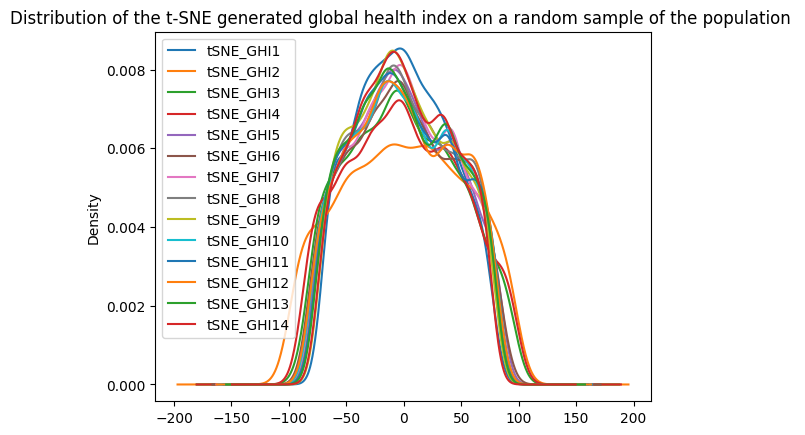

In [22]:
data_global_health_index_rand.drop(columns=["HHIDPN"]).plot.density()
plt.title("Distribution of the t-SNE generated global health index on a random sample of the population ")
plt.show()

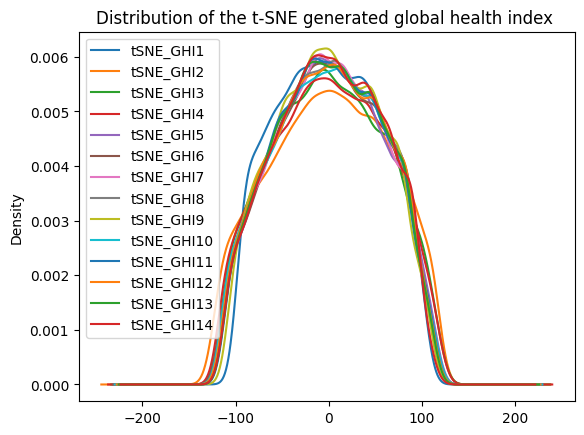

In [28]:
health_index.drop(columns=["HHIDPN"]).plot.density()
plt.title("Distribution of the t-SNE generated global health index ")
plt.show()

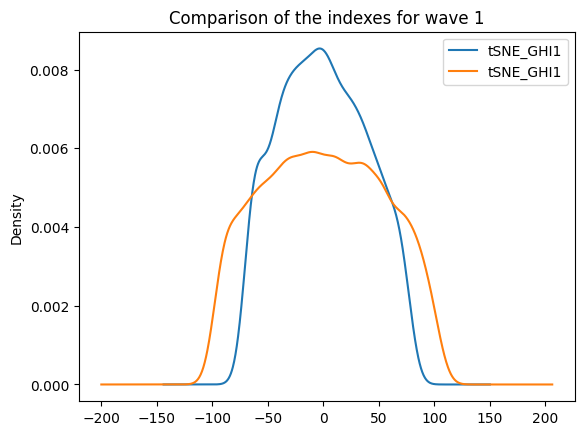

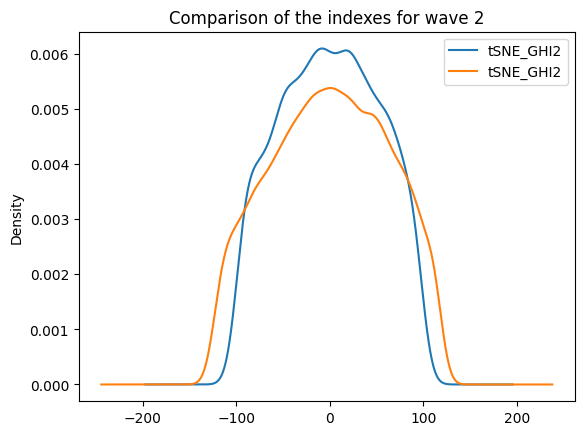

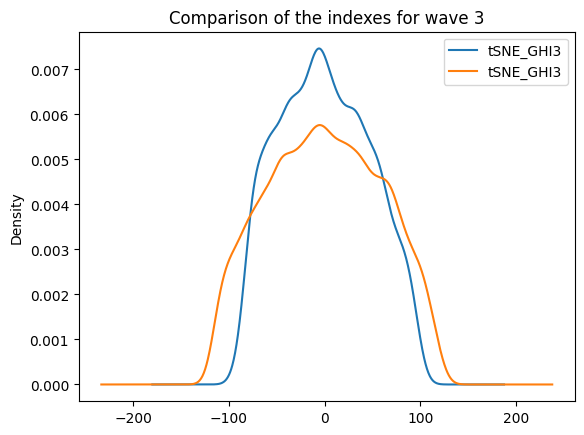

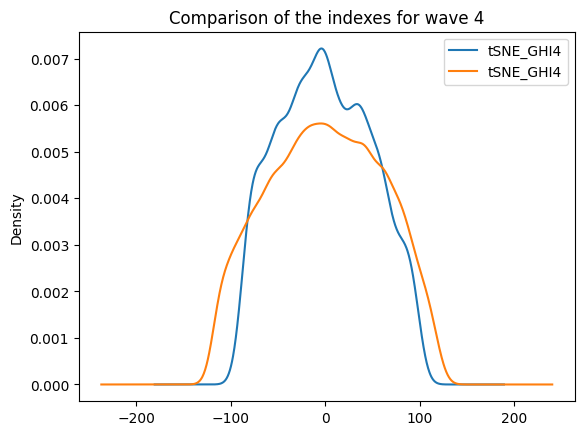

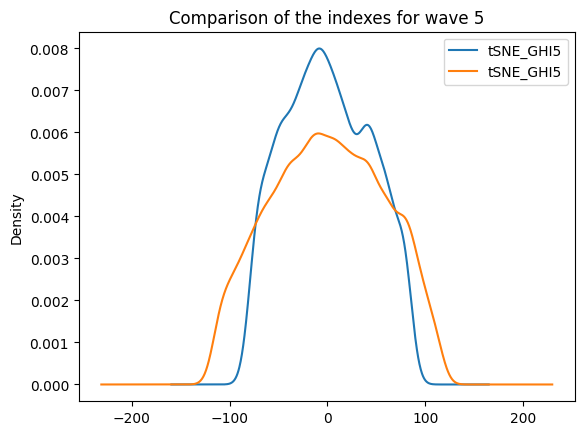

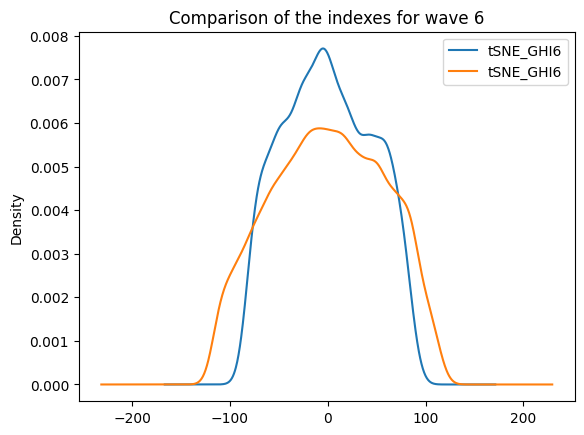

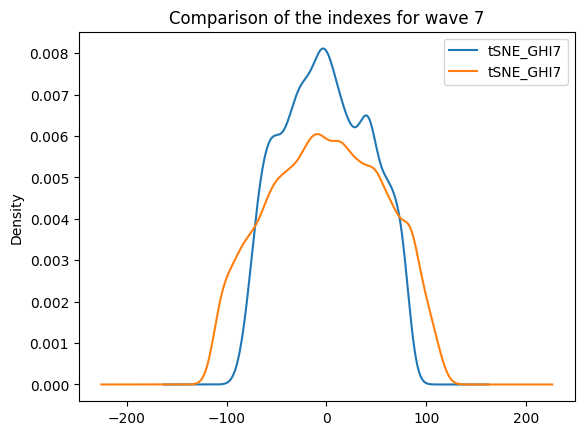

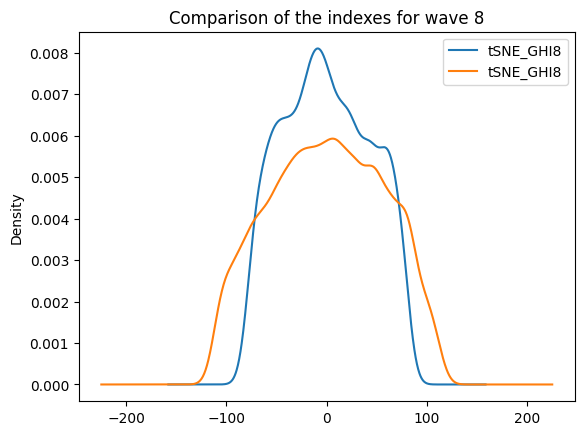

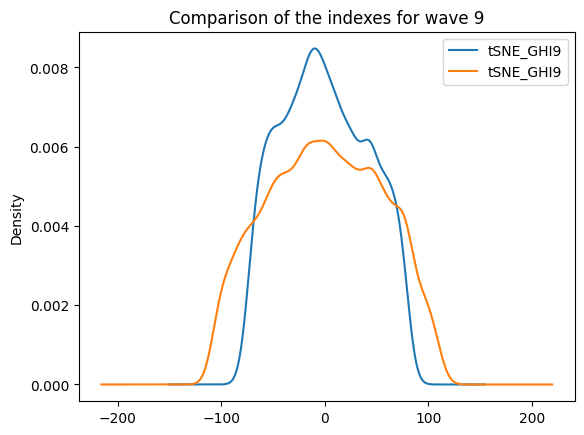

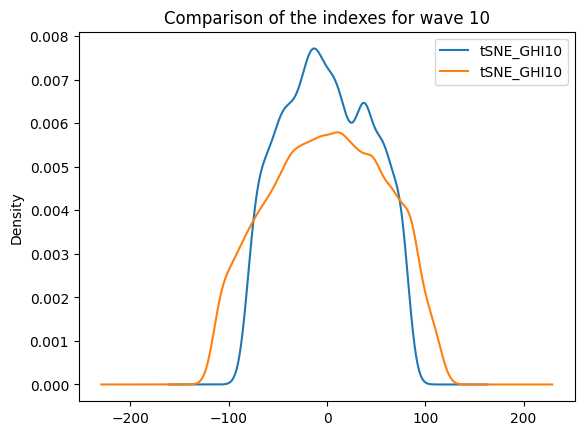

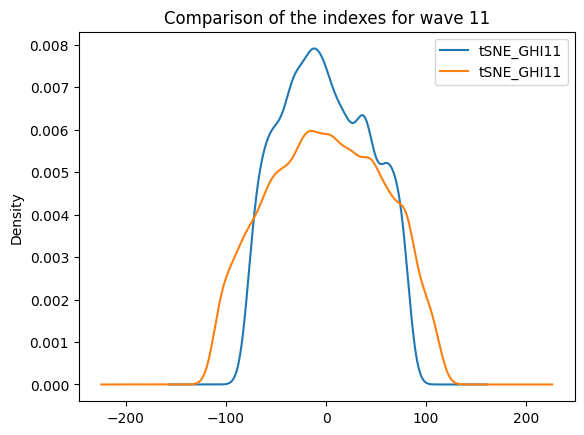

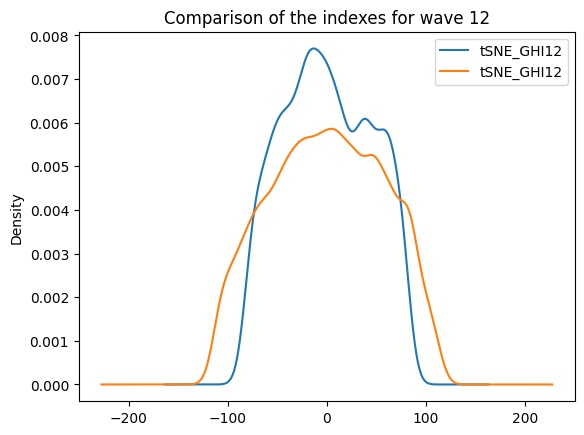

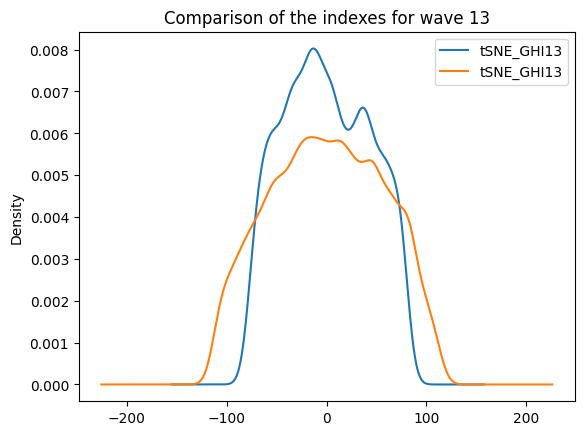

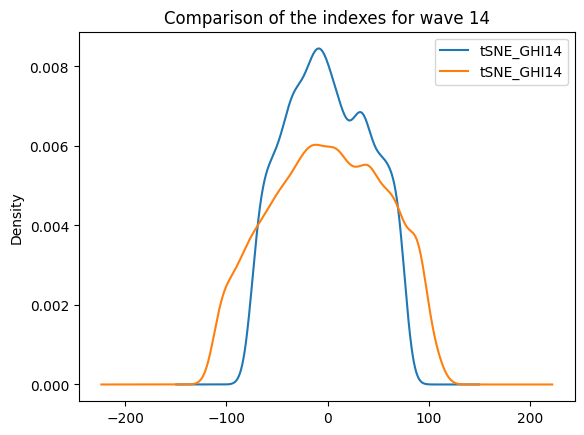

In [27]:
for i in range(1,15):
    data_global_health_index_rand[f"tSNE_GHI{i}"].plot.density()
    health_index[f"tSNE_GHI{i}"].plot.density()
    plt.title("Comparison of the indexes for wave " + str(i))
    plt.legend()
    plt.show()

When comparing the two distributions, we get the same conclusion for each wave: the shapes of the distributions are similar, the difference being the standard deviation. This is due to the fact that the standard deviation increases when the number of observations decreases. Here, we used 42233 observations to obtain the blue curve and 10000 for the orange curve. The more observations we use, the more the density curve is close to the one using all the data.
This analysis gives evidence that the index is robust.

Now, we delete values at random in the initial dataframe, then create the index and compare the results.

In [87]:
data_nan = data.mask(np.random.random(data.shape) < 0.1)

In [88]:
health_data_nan = data_nan[["HHIDPN"] + in_waves + health_variables]
data_global_health_index_nan = data_nan[["HHIDPN"]+in_waves].copy()

In [89]:
for wave in range(1, 15):
    print(f"Wave {wave}:", end=" ")

  # Get data
    data_wave = get_wave(health_data_nan, wave)
    X = data_wave.drop(columns=["HHIDPN"]).values
    print("Data saved", end=" ; ")

  # Preprocessing
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    print("Data scaled", end=" ; ")

  # Imputing missing values
    imputer = IterativeImputer(max_iter=120)
    X_imputed = imputer.fit_transform(X_scaled)
    print("Missing values imputed", end=" ; ")

  # Creating the index
    tSNE = TSNE(n_components=1) # We only take one component because we wish to create an index
    health_index_wave = tSNE.fit_transform(X_imputed) # Index created
    health_index_wave = StandardScaler(with_std=False).fit_transform(health_index_wave) # We mean-center the index
    print("Health index created", end=" ; ")

  # Storing the index
    data_global_health_index_nan.loc[data_global_health_index_nan[f"INW{wave}"]==1, f"tSNE_GHI{wave}"] = health_index_wave
    print("Health index stored.\n")

Wave 1: Data saved ; Data scaled ; Missing values imputed ; Health index created ; Health index stored.

Wave 2: Data saved ; Data scaled ; Missing values imputed ; Health index created ; Health index stored.

Wave 3: Data saved ; Data scaled ; Missing values imputed ; Health index created ; Health index stored.

Wave 4: Data saved ; Data scaled ; Missing values imputed ; Health index created ; Health index stored.

Wave 5: Data saved ; Data scaled ; Missing values imputed ; Health index created ; Health index stored.

Wave 6: Data saved ; Data scaled ; Missing values imputed ; Health index created ; Health index stored.

Wave 7: Data saved ; Data scaled ; Missing values imputed ; Health index created ; Health index stored.

Wave 8: Data saved ; Data scaled ; 

C:\Users\julie\miniconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Missing values imputed ; Health index created ; Health index stored.

Wave 9: Data saved ; Data scaled ; Missing values imputed ; Health index created ; Health index stored.

Wave 10: Data saved ; Data scaled ; Missing values imputed ; Health index created ; Health index stored.

Wave 11: Data saved ; Data scaled ; Missing values imputed ; Health index created ; Health index stored.

Wave 12: Data saved ; Data scaled ; 

C:\Users\julie\miniconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Missing values imputed ; Health index created ; Health index stored.

Wave 13: Data saved ; Data scaled ; Missing values imputed ; Health index created ; Health index stored.

Wave 14: Data saved ; Data scaled ; 

C:\Users\julie\miniconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Missing values imputed ; Health index created ; Health index stored.



In [90]:
data_global_health_index_nan = data_global_health_index_nan.drop(columns = in_waves)

In [91]:
data_global_health_index_nan.describe()

,HHIDPN,tSNE_GHI1,tSNE_GHI2,tSNE_GHI3,tSNE_GHI4,tSNE_GHI5,tSNE_GHI6,tSNE_GHI7,tSNE_GHI8,tSNE_GHI9,tSNE_GHI10,tSNE_GHI11,tSNE_GHI12,tSNE_GHI13,tSNE_GHI14
count,3.804400e+04,11358.000000,17739.000000,1.624900e+04,1.922400e+04,1.766900e+04,1.629700e+04,1.811300e+04,1.663500e+04,1.552000e+04,1.973900e+04,1.842700e+04,1.683800e+04,1.889700e+04,1.543700e+04
mean,2.891658e+08,-0.000001,-0.000001,-4.357239e-07,2.031965e-07,-3.454364e-07,-5.393056e-07,-3.234900e-07,-7.631688e-07,-5.663056e-07,-8.843434e-07,3.842231e-07,-7.249692e-07,5.684599e-07,-6.484269e-07
std,2.516116e+08,50.766514,57.921326,5.667822e+01,5.589724e+01,5.442992e+01,5.471273e+01,5.418045e+01,5.417865e+01,5.229539e+01,5.416183e+01,5.399698e+01,5.445157e+01,5.405873e+01,5.357824e+01
min,1.010000e+03,-92.327744,-109.500443,-1.068941e+02,-1.058113e+02,-1.060838e+02,-1.061816e+02,-1.052243e+02,-1.038866e+02,-9.877991e+01,-1.054186e+02,-1.052420e+02,-1.053016e+02,-1.063451e+02,-1.035880e+02
25%,7.335451e+07,-41.411491,-46.845161,-4.638919e+01,-4.595653e+01,-4.311081e+01,-4.338044e+01,-4.265776e+01,-4.371095e+01,-4.237833e+01,-4.311016e+01,-4.264697e+01,-4.346457e+01,-4.236116e+01,-4.254601e+01
50%,2.046580e+08,-1.539116,0.079205,-6.622279e-01,-5.416240e-01,-1.091105e-01,2.400572e-01,-1.413777e-01,1.083104e-01,8.304686e-02,6.108392e-01,-1.953133e-01,6.505225e-01,6.625392e-01,1.567925e-01
75%,5.228528e+08,41.004242,45.764656,4.493447e+01,4.438000e+01,4.316660e+01,4.387912e+01,4.386736e+01,4.367234e+01,4.300550e+01,4.357343e+01,4.360602e+01,4.439393e+01,4.362454e+01,4.328217e+01
max,9.597380e+08,101.145714,110.890465,1.172998e+02,1.165507e+02,1.107812e+02,1.116240e+02,1.113616e+02,1.102174e+02,1.070304e+02,1.094426e+02,1.102424e+02,1.099872e+02,1.101251e+02,1.069999e+02


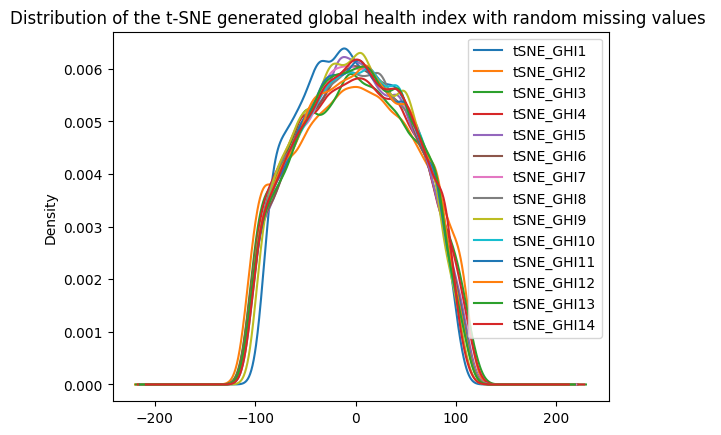

In [92]:
data_global_health_index_nan.drop(columns=["HHIDPN"]).plot.density()
plt.title("Distribution of the t-SNE generated global health index with random missing values ")
plt.show()

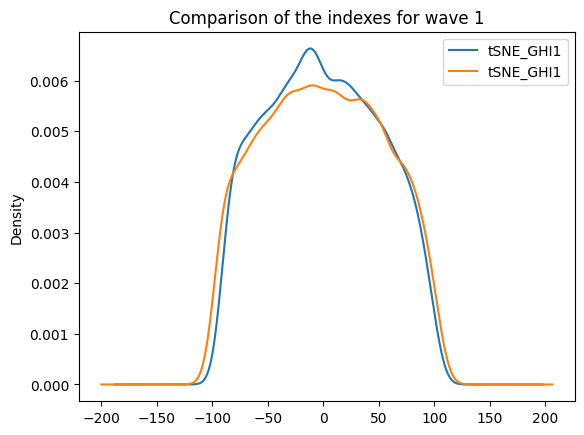

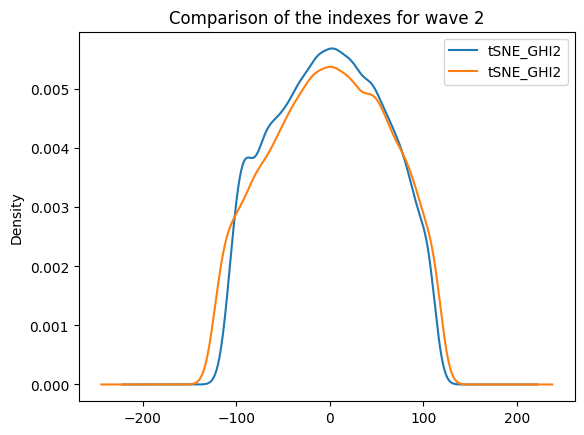

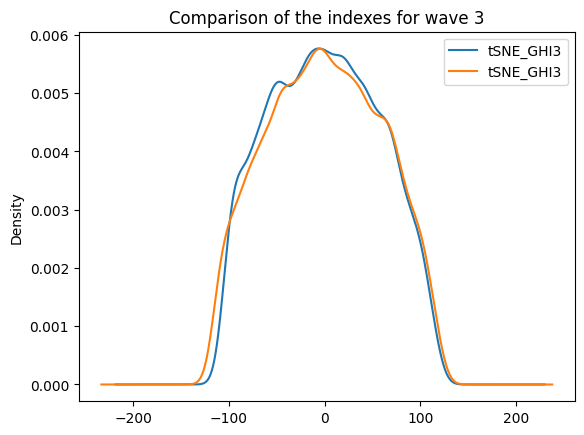

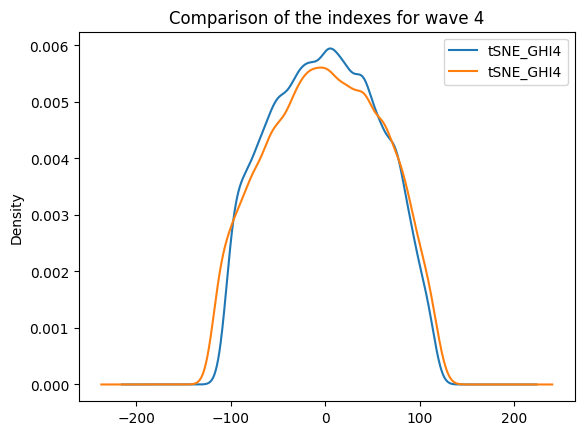

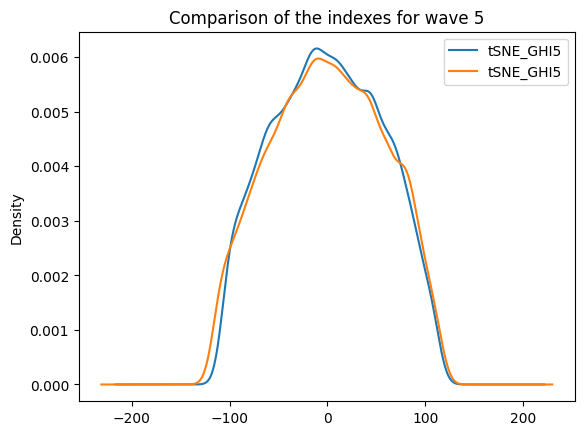

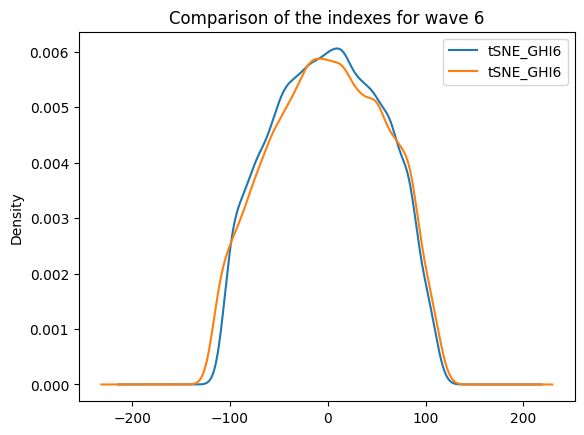

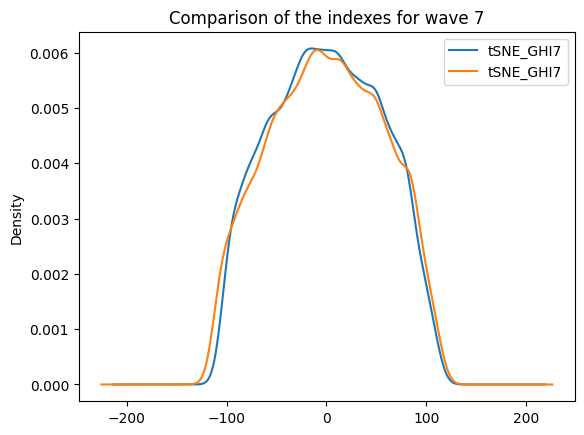

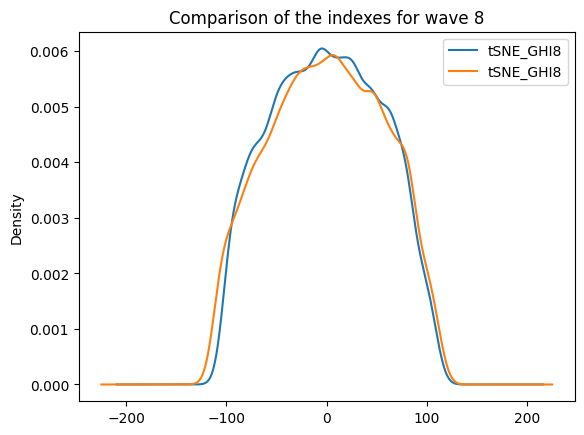

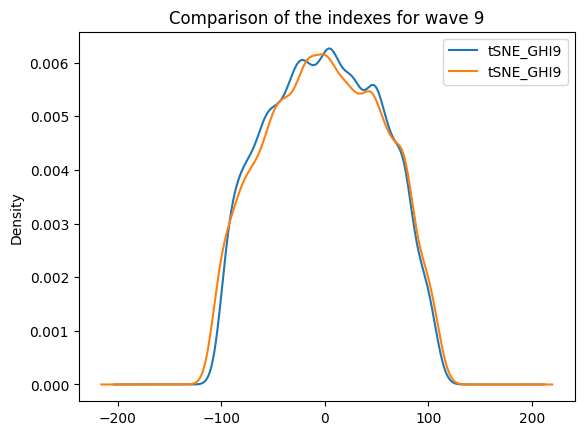

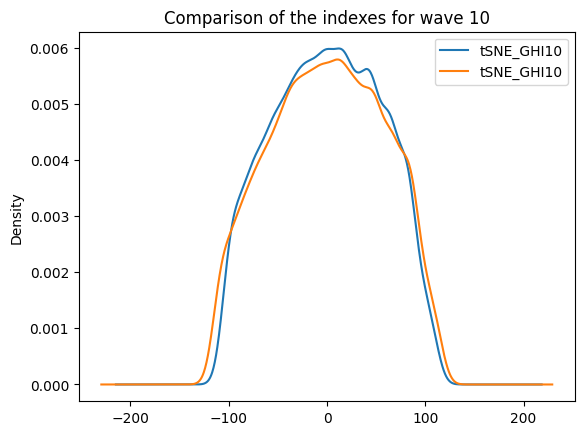

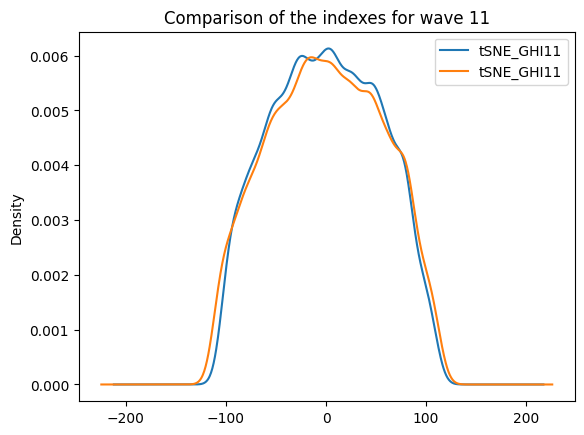

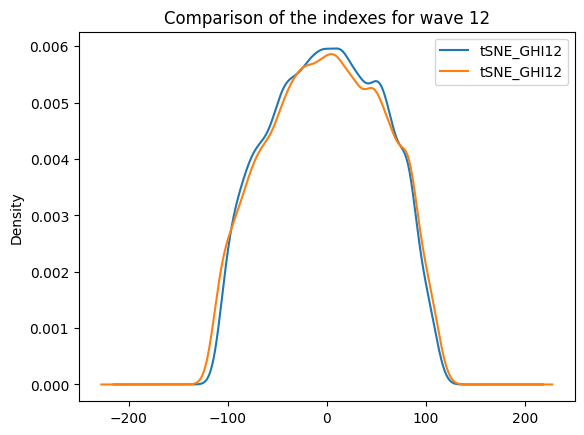

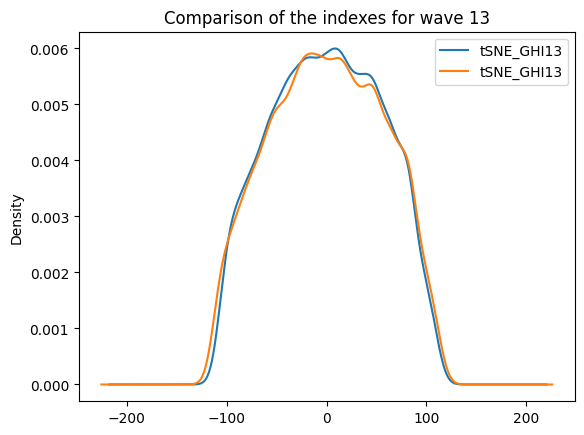

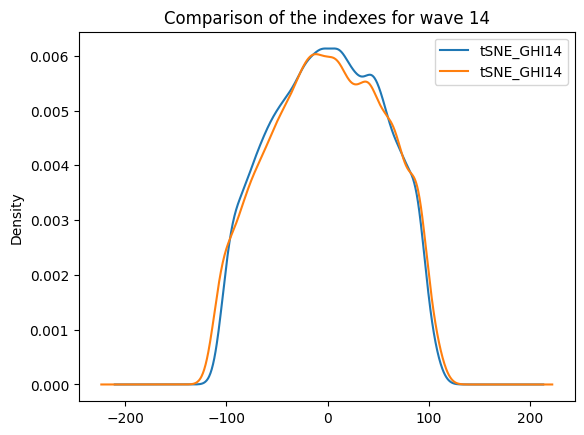

In [36]:
for i in range(1,15):
    data_global_health_index_nan[f"tSNE_GHI{i}"].plot.density()
    health_index[f"tSNE_GHI{i}"].plot.density()
    plt.title("Comparison of the indexes for wave " + str(i))
    plt.legend()
    plt.show()

In [93]:
merged_index_nan = pd.merge(health_index, data_global_health_index_nan, on="HHIDPN", how="inner")
merged_index_nan.head()

,HHIDPN,tSNE_GHI1_x,tSNE_GHI2_x,tSNE_GHI3_x,tSNE_GHI4_x,tSNE_GHI5_x,tSNE_GHI6_x,tSNE_GHI7_x,tSNE_GHI8_x,tSNE_GHI9_x,...,tSNE_GHI5_y,tSNE_GHI6_y,tSNE_GHI7_y,tSNE_GHI8_y,tSNE_GHI9_y,tSNE_GHI10_y,tSNE_GHI11_y,tSNE_GHI12_y,tSNE_GHI13_y,tSNE_GHI14_y
0,1010,46.338680,68.969490,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010,64.833760,-13.297101,27.734835,43.220688,44.066593,NaN,NaN,NaN,NaN,...,-66.656128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3010,22.931510,-66.686300,-29.234972,13.921358,-91.249150,-44.982487,-73.210106,-93.987110,-26.113197,...,-58.644550,NaN,-98.893105,-62.148182,-86.263107,-45.391357,-29.206860,NaN,NaN,NaN
3,3020,87.220850,26.626232,-3.540929,-35.344840,5.839192,15.979321,87.244750,7.659104,7.514696,...,7.929940,20.611666,84.549324,32.288799,4.530884,14.079593,7.743630,83.614029,NaN,NaN
4,10001010,16.348322,51.236960,-34.807380,16.018581,-20.836510,-49.169600,-41.571840,-27.421490,104.275900,...,-24.553123,-31.116179,-25.566895,-24.368053,101.301048,-27.125233,-26.583542,-51.816959,-60.696461,NaN


In [94]:
means2 = merged_index_nan.mean()
merged_index_nan = merged_index.fillna(means2)
merged_index_nan.drop("HHIDPN", axis=1).describe()

,tSNE_GHI1_x,tSNE_GHI2_x,tSNE_GHI3_x,tSNE_GHI4_x,tSNE_GHI5_x,tSNE_GHI6_x,tSNE_GHI7_x,tSNE_GHI8_x,tSNE_GHI9_x,tSNE_GHI10_x,...,tSNE_GHI5_y,tSNE_GHI6_y,tSNE_GHI7_y,tSNE_GHI8_y,tSNE_GHI9_y,tSNE_GHI10_y,tSNE_GHI11_y,tSNE_GHI12_y,tSNE_GHI13_y,tSNE_GHI14_y
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,10000.000000
mean,0.332786,-0.077345,0.705505,0.174923,0.357020,0.692150,-0.223422,-0.691065,-1.385486,-1.109010,...,-5.040970e-07,-1.873932e-07,-3.668134e-07,-2.656321e-07,2.386407e-07,-1.342773e-07,3.997803e-07,-2.243042e-07,1.464844e-07,0.000000
std,29.481271,42.489462,38.462995,42.672357,38.865517,38.032431,39.074341,37.658023,35.302156,41.566597,...,2.962981e+01,2.948575e+01,2.951857e+01,2.841980e+01,2.625432e+01,3.160499e+01,3.005433e+01,2.947642e+01,3.008142e+01,25.909807
min,-98.426160,-123.562240,-115.600920,-117.569595,-115.796870,-116.151860,-112.551330,-112.191470,-107.001690,-114.975470,...,-7.829063e+01,-8.210750e+01,-8.184477e+01,-7.872910e+01,-7.401434e+01,-7.997121e+01,-7.755010e+01,-8.139310e+01,-7.655087e+01,-74.493034
25%,0.332786,-0.077345,0.705505,-1.693459,0.357020,0.692150,-0.223422,-0.691065,-1.385486,-4.790579,...,-6.276109e-07,-2.262656e-07,-4.084327e-07,-3.889359e-07,2.396472e-07,-4.164435e+00,-7.976840e-01,-3.645327e-07,-2.331177e+00,0.000000
50%,0.332786,-0.077345,0.705505,0.174923,0.357020,0.692150,-0.223422,-0.691065,-1.385486,-1.109010,...,-6.276109e-07,-2.262656e-07,-4.084327e-07,-3.889359e-07,2.396472e-07,-2.125837e-07,5.788901e-07,-3.645327e-07,2.448753e-07,0.000000
75%,0.332786,-0.077345,0.705505,2.675570,0.357020,0.692150,-0.223422,-0.691065,-1.385486,1.174508,...,-6.276109e-07,-2.262656e-07,-4.084327e-07,-3.889359e-07,2.396472e-07,6.622788e-01,5.788901e-07,-3.645327e-07,2.448753e-07,0.000000
max,104.658520,117.422455,119.932140,120.819620,114.485060,114.225340,113.366810,112.590454,110.599670,113.963930,...,8.361511e+01,8.687972e+01,8.069445e+01,7.954285e+01,7.816256e+01,8.229825e+01,8.120852e+01,8.150467e+01,7.964869e+01,74.654877


In [96]:
rmse_range_by_wave_nan = []
percentage_err_nan = []
for i in range(1,15):
    rmse_range_by_wave_nan.append([np.sqrt(mean_squared_error(merged_index_nan[f"tSNE_GHI{i}_x"], merged_index_nan[f"tSNE_GHI{i}_y"])), np.max(health_index[f"tSNE_GHI{i}"]) - np.min(health_index[f"tSNE_GHI{i}"])])
    percentage_err_nan.append(np.sqrt(mean_squared_error(merged_index_nan[f"tSNE_GHI{i}_x"], merged_index_nan[f"tSNE_GHI{i}_y"]))/(np.max(health_index[f"tSNE_GHI{i}"]) - np.min(health_index[f"tSNE_GHI{i}"])))

In [97]:
rmse_range_by_wave_nan

[[21.754364971495573, 203.157155],
 [12.217796732202217, 241.04883999999998],
 [19.260509049661565, 235.623],
 [17.771641341159878, 238.41155],
 [19.743205433885596, 230.30147399999998],
 [19.201743318388658, 230.42199],
 [23.542213625399008, 225.91814],
 [18.495014403328867, 224.811274],
 [18.755345212921934, 217.69333],
 [20.801012767546062, 229.40155],
 [15.714677529770833, 225.313492],
 [20.906269010331698, 227.491385],
 [16.867005538403827, 225.673505],
 [18.041971926626264, 222.71561]]

In [98]:
percentage_err_nan

[0.10708146100734466,
 0.05068598020302532,
 0.08174290731236579,
 0.07454186402110081,
 0.08572765554199448,
 0.08333294629730721,
 0.10420683184360055,
 0.08226906984802224,
 0.08615489143797807,
 0.09067511866221507,
 0.06974583452716997,
 0.09189916800731464,
 0.07474074343997017,
 0.08100901381194728]

The error is 10% or less.